In [1]:
import numpy as np
import os
import PIL
from PIL import Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
from pyspark import SparkFiles
from pyspark.sql.session import SparkSession
spark = SparkSession.builder.appName('Flower classification').getOrCreate()
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

In [3]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
!ls $data_dir

daisy  dandelion  LICENSE.txt  roses  sunflowers  tulips


In [5]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


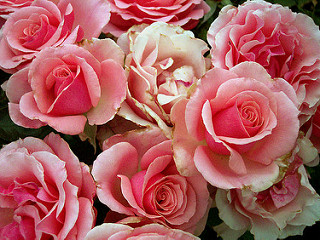

In [6]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

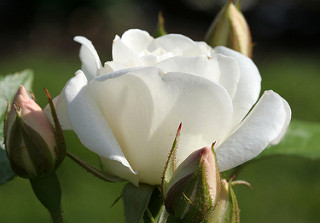

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

In [8]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
 
from pyspark.sql.functions import col, pandas_udf, PandasUDFType

In [9]:
model = ResNet50()
bc_model_weights = spark.sparkContext.broadcast(model.get_weights())

In [10]:
import os
local_dir =data_dir
files = [os.path.join(dp, f) for dp, dn, filenames in os.walk(local_dir) for f in filenames if os.path.splitext(f)[1] == '.jpg']
files = files[:500]
len(files)

500

In [11]:
import pandas as pd
image_data = []
for file in files:
    img = Image.open(file)
    img = img.resize([224, 224])
    data = np.asarray( img, dtype="float32" ).reshape([224*224*3])

    image_data.append({"data": data})

pandas_df = pd.DataFrame(image_data, columns = ['data'])
pandas_df.to_parquet('data/new_image')

In [12]:
from pyspark.sql.types import *
df = spark.read.parquet('data/new_image')
print(df.count())

500


In [13]:
# Decrease the batch size of the Arrorw reader to avoid OOM errors on smaller instance types.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [14]:
assert len(df.head()) > 0, "`df` should not be empty" # This line will fail if the vectorized reader runs out of memory

In [15]:
def parse_image(image_data):
    image = tf.image.convert_image_dtype(image_data, dtype=tf.float32) * (2. / 255) - 1
    image = tf.reshape(image,[224,224,3])
    return image

In [16]:
@pandas_udf(ArrayType(FloatType()), PandasUDFType.SCALAR_ITER)
def predict_batch_udf(image_batch_iter):
    batch_size = 64
    model = ResNet50(weights=None)
    model.set_weights(bc_model_weights.value)
    for image_batch in image_batch_iter:
        images = np.vstack(image_batch)
        dataset = tf.data.Dataset.from_tensor_slices(images)
        dataset = dataset.map(parse_image, num_parallel_calls=8).prefetch(5000).batch(batch_size)
        preds = model.predict(dataset)
        yield pd.Series(list(preds))

/usr/local/spark/python/pyspark/sql/pandas/functions.py:394: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


In [17]:
predictions_df = df.select(predict_batch_udf(col("data")).alias("prediction"))
predictions_df.write.mode("overwrite").parquet('data/new_image_out')

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 48930)
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/opt/conda/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/opt/conda/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/usr/local/spark/python/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/usr/local/spark/python/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/usr/local/spark/python/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = read_int(self.rfile)
  File "/usr/local/spark/python/

Py4JError: An error occurred while calling o54.parquet

In [ ]:
result_df = spark.read.parquet(output_file_path)
display(result_df[0])

In [ ]:
#!rm -rf !data_dir
#!rm -rf data
!mkdir data